<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/focus_MM/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Dataset preparation

In [1]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
from tqdm.keras import TqdmCallback
import gc
import time 
# import numba
import os
import scipy.fftpack
import cv2
import random
from scipy.special import gamma


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow import keras

import tensorflow_hub as hub

#import model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

sr = 44100
sr = 16000
# sr = 22050

In [3]:
! pip install icecream --quiet
from icecream import ic

In [2]:
! pip install samplerate --quiet
import samplerate

     |████████████████████████████████| 4.0MB 7.8MB/s 


In [ ]:
! pip install optuna --quiet
import optuna

     |████████████████████████████████| 307kB 5.0MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 174kB 17.4MB/s 
     |████████████████████████████████| 143kB 19.4MB/s 
     |████████████████████████████████| 112kB 16.9MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 


In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

In [ ]:
! pip install audiomentations --quiet
import audiomentations as am

     |████████████████████████████████| 184kB 8.4MB/s 


Get Dataset

In [4]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4154 (delta 10), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4154/4154), 878.78 MiB | 31.82 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (2011/2011), done.


In [5]:
ROOT = '/content/ESC-50/audio/'

data_info = pd.read_csv(ROOT+"../meta/esc50.csv")

#make a category dictionary
category_dict = dict(zip(data_info['target'], data_info['category']))
data_info

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


# Part 1: Baseline ConvNet


## Preprocessing and input pipeline functions

In [ ]:
class AudioLoader():
    def __init__(self, df, root, format1=False, downsample=True):
        self.df = df
        self.root = root
        self.format1 = format1
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.downsample:
            this_audio = samplerate.resample(this_audio, 16000/44100, converter_type='sinc_fastest')
        if self.format1:
            this_audio = this_audio / 32768     # 2^15 = 32768
        return this_audio

    def get_info(self, idx, list=False):
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out

def get_mel(y):
    mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(y.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_mels=128))
    mel = (mel - np.min(mel))/(np.max(mel) - np.min(mel))
    return mel

def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed


def base_features_preprocessor(audio_loader, path, df, augmentation=0):

    augment = am.Compose([
    am.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    am.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    am.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    am.Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),])


    if augmentation==0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            this_mel = get_mel(this_audio)
            pack = np.array([this_mel, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype= 'object')
            np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
            # break

    if augmentation > 0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            for aug in range(augmentation):
                
                if aug == 0:
                    this_mel = get_mel(this_audio)
                    pack = np.array([this_mel, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
                else:
                    aug_audio = augment(this_audio, sr)
                    this_mel = get_mel(this_audio)
                    pack = np.array([this_mel, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_'+str(aug)), pack)


filename    1-11687-A-47.wav
fold                       1
target                    47
category            airplane
esc10                  False
src_file               11687
take                       A
Name: 25, dtype: object


ic| asd.shape: (128, 500)


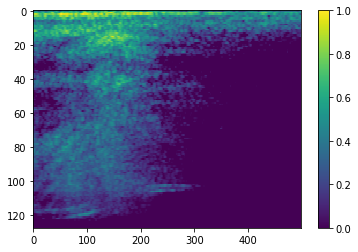

In [ ]:
audio_loader = AudioLoader(data_info, ROOT, format1=True, downsample=True)
asd = get_mel(audio_loader[25])
print(audio_loader.get_info(25))
ic(asd.shape)

plt.figure()
plt.imshow(asd, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

## Offline preprocessing of the dataset

In [ ]:
ic(ROOT)
AUGMENTATION = 0

!mkdir -p baseline_storage
path_base = "/content/baseline_storage/"

audio_loader = AudioLoader(data_info, ROOT, format1=True)
base_features_preprocessor(audio_loader, path_base, data_info, augmentation=AUGMENTATION)

ic| ROOT: '/content/ESC-50/audio/'


## Sequence class

In [ ]:
def to_onehot(y, classes=50):
    y_oh = np.zeros((classes, 1))
    y_oh[y] = 1
    return y_oh

def mix(a, b, l):
    return l*b + (1-l)*a


class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, alpha_schedule=None, mixup='none', wait_mix=0):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.mixup = mixup
        self.epoch = 0
        self.alpha = [0.01, 0.01]
        self.mix_prob = 1
        self.wait_mix = wait_mix
        if self.mixup != 'none':
            self.alpha_schedule = alpha_schedule
        else:
            self.alpha_schedule = None

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.mixup != 'none' and self.epoch < self.alpha_schedule.shape[1]:
            self.alpha = self.alpha_schedule[:,self.epoch]

        # print('deb alpha', self.alpha[0], self.alpha[1])
        random.shuffle(self.names)

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            this_feat = this_pack[0]
            this_target = to_onehot(this_pack[2])
            
            if self.mixup != 'none' and self.epoch >= self.wait_mix:
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                this_feat2 = np.roll(this_feat2, np.random.randint(0,10), axis=0)
                this_target2 = to_onehot(this_pack2[2])

                if self.mixup == 'lossy':
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, this_feat2, l)

                elif self.mixup == 'standard':
                    # mix the samples and the target
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, this_feat2, l)
                    this_target = mix(this_target, this_target2, l)  

                elif self.mixup == 'noise':
                    #use gaussian noise instead of the sample
                    feat2_std = np.std(this_feat2)
                    feat2_mean = np.mean(this_feat2)
                    noise_feat2 = np.random.normal(feat2_mean, feat2_std, this_feat2.shape)
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, noise_feat2, l)


            batch_feat.append(this_feat)
            batch_target.append(this_target)

        batch_input = np.array(batch_feat)
        # ic(batch_infered.shape, type(batch_infered))

        batch_target = np.array(batch_target)
        # batch_input = batch_infered

        return batch_input, batch_target


Visualization function

In [ ]:
def training_eval(fold_history):
    loss = np.zeros((len(fold_history[0]['loss']),))
    accuracy = np.zeros((len(fold_history[0]['accuracy']),))
    val_loss = np.zeros((len(fold_history[0]['val_loss']),))
    val_accuracy = np.zeros((len(fold_history[0]['val_accuracy']),))

    best_val_acc = []
    plt.figure(figsize=(10,8))
    for i, d in enumerate(fold_history):
        plt.plot(d['val_accuracy'], label='fold '+str(i))

        best_val_acc.append(np.max(d['val_accuracy'])) 
        loss += np.array(list(d['loss']))
        # ic(loss.shape)
        accuracy += np.array(list(d['accuracy']))
        # ic(accuracy.shape)
        val_loss += np.array(list(d['val_loss']))
        # ic(val_loss.shape)
        val_accuracy += np.array(list(d['val_accuracy']))
        # ic(val_accuracy.shape)

    plt.title('Fold accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle=':')
    loss /= 5
    accuracy /= 5
    val_loss /= 5
    val_accuracy /= 5

    val_accuracy_std = np.std(val_accuracy)
    accuracy_std = np.std(accuracy)
    plt.figure(figsize=(10,8))
    plt.plot(accuracy, label='train_acc')
    plt.plot(val_accuracy, label='val_acc')
    # plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
    # plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
    plt.legend()
    plt.title('Avg fold scores')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(linestyle=':')
    plt.show()

    print(f'Best validation accuracy {max(best_val_acc)} on fold {np.argmax(best_val_acc)}.')
    print(f'Average on folds of the best validation accuracies: {sum(best_val_acc)/len(best_val_acc)}.')


## baseline convolutional model definition

In [ ]:
def make_baseConvNet(lr):

    drop = 0.2
    input_shape = (500, 128,1)
    input = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), strides=(1,1), padding='same')(input)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(drop)(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(drop)(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(drop)(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(drop)(x)
    x = layers.MaxPool2D((2,2))(x)


    x = layers.GlobalAveragePooling2D()(x)
    x = tf.expand_dims(x, axis=1)

    x = layers.Conv1D(50, 1)(x)
    x = layers.Dropout(drop)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(50, 1)(x)
    x = layers.Softmax()(x)

    x = layers.GlobalAveragePooling1D()(x)

    model = keras.Model(inputs=input, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model

baseline_model = make_baseConvNet(0.001)
baseline_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 500, 128, 32)      320       
_________________________________________________________________
re_lu (ReLU)                 (None, 500, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 128, 32)      9248      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 500, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 64, 32)       0     

## Training with no mixup

In [ ]:
SOURCE = path_base
MIXUP = 'none'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'

batch_size = 64
epochs = 300

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]   

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                                patience=5, min_lr=0.00001)

    baseline_model = make_baseConvNet(0.0005)
    # Model training
    history = baseline_model.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                #    PlotLossesKeras(),
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                #    model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'baseline_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()
     



--- Training on fold 1 ---



Best validation accuracy: 0.5963541865348816

--- Training on fold 2 ---



Best validation accuracy: 0.6276041865348816

--- Training on fold 3 ---



Best validation accuracy: 0.6614583134651184

--- Training on fold 4 ---



Best validation accuracy: 0.6848958134651184

--- Training on fold 5 ---



Best validation accuracy: 0.5729166865348816



ic| loss.shape: (300,)
ic| accuracy.shape: (300,)
ic| val_loss.shape: (300,)
ic| val_accuracy.shape: (300,)
ic| loss.shape: (300,)
ic| accuracy.shape: (300,)
ic| val_loss.shape: (300,)
ic| val_accuracy.shape: (300,)
ic| loss.shape: (300,)
ic| accuracy.shape: (300,)
ic| val_loss.shape: (300,)
ic| val_accuracy.shape: (300,)
ic| loss.shape: (300,)
ic| accuracy.shape: (300,)
ic| val_loss.shape: (300,)
ic| val_accuracy.shape: (300,)
ic| loss.shape: (300,)
ic| accuracy.shape: (300,)
ic| val_loss.shape: (300,)
ic| val_accuracy.shape: (300,)


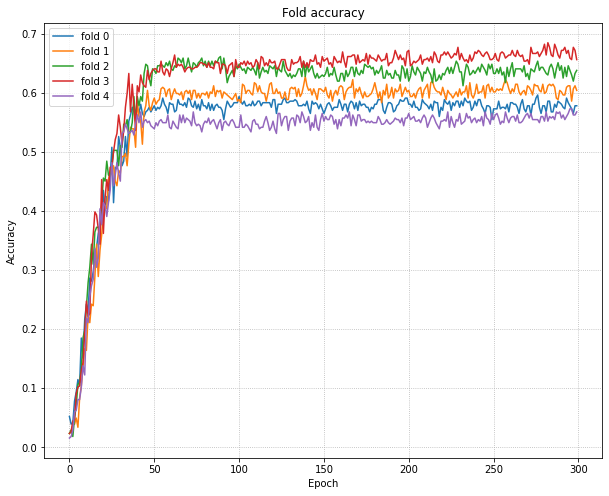

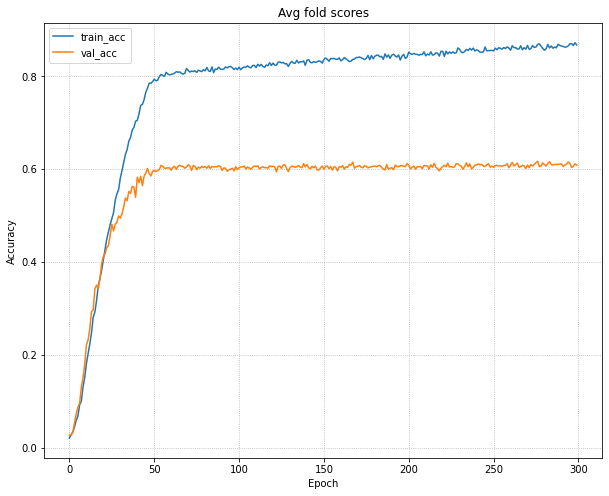

Best validation accuracy 0.6848958134651184 on fold 3.
Average on folds of the best validation accuracies: 0.6286458373069763.


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'
fold_history_bnone = np.load(os.path.join(SAVE_PATH, 'baseline_none.npy'), allow_pickle=True)

training_eval(fold_history_bnone)

## Test standard mixup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


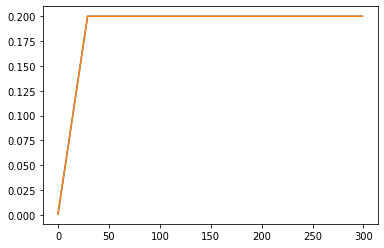

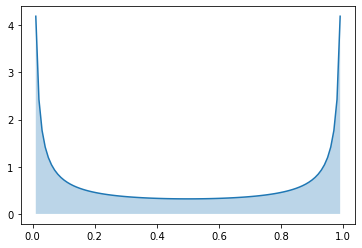

In [ ]:
epoch = 300
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.2
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end

plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(np.linspace(0,1,100),beta)
plt.fill_between(np.linspace(0,1,100),beta, alpha=0.3 )

In [ ]:
SOURCE = path_base
MIXUP = 'standard'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'

batch_size = 64
epochs = 300

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]   

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                                patience=5, min_lr=0.00001)

    baseline_model = make_baseConvNet(0.0005)
    # Model training
    history = baseline_model.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                #    PlotLossesKeras(),
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                #    model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'baseline_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()
     



--- Training on fold 1 ---



Best validation accuracy: 0.6979166865348816

--- Training on fold 2 ---



Best validation accuracy: 0.6796875

--- Training on fold 3 ---



Best validation accuracy: 0.65625

--- Training on fold 4 ---



Best validation accuracy: 0.7239583134651184

--- Training on fold 5 ---



Best validation accuracy: 0.671875



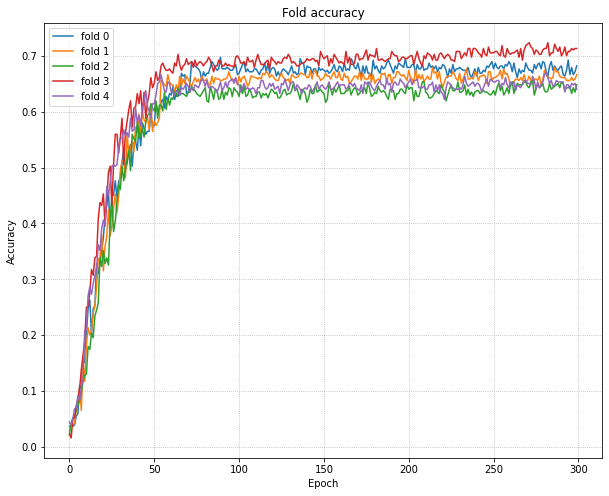

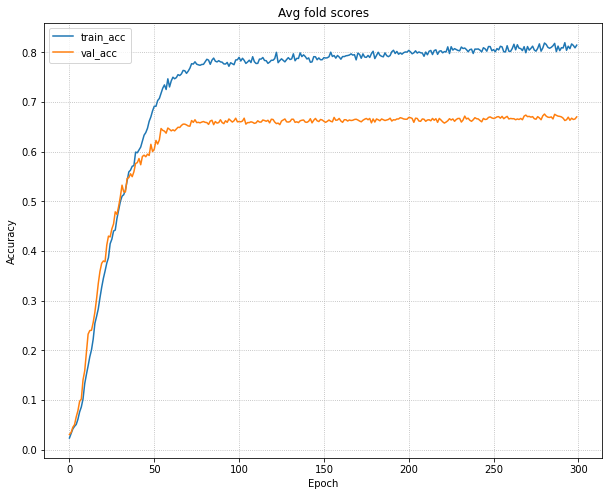

Best validation accuracy 0.7239583134651184 on fold 3.
Average on folds of the best validation accuracies: 0.6859375.


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'
fold_history_bstandard = np.load(os.path.join(SAVE_PATH, 'baseline_standard.npy'), allow_pickle=True)

training_eval(fold_history_bstandard)

## Test lossy mixup



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

divide by zero encountered in power



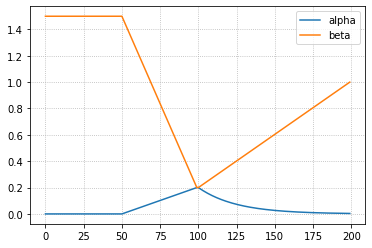

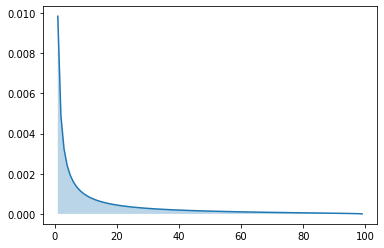

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-4
alpha_end = 0.2
alpha_schedule[:,0:50] = alpha_start
alpha_schedule[0,50:100] = np.linspace(alpha_start, alpha_end, 50)
alpha_schedule[0,100:] = alpha_end*np.exp(-np.linspace(0,4, 100))
alpha_schedule[1,100:] = np.linspace(alpha_end, 1, 100)
alpha_schedule[1,0:50] = 1.5
alpha_schedule[1,50:100] = np.linspace(1.5,alpha_end, 50)
plt.figure()
plt.plot(alpha_schedule[0], label='alpha')
plt.plot(alpha_schedule[1], label='beta')
plt.legend()
plt.grid(linestyle=':')

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )
plt.show()

In [ ]:
SOURCE = path_base
MIXUP = 'lossy'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'

batch_size = 64
epochs = 200

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]   

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP, wait_mix=50)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                                patience=5, min_lr=0.00001)

    baseline_model = make_baseConvNet(0.001)
    # Model training
    history = baseline_model.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                #    PlotLossesKeras(),
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                #    model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'baseline_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()
     



--- Training on fold 1 ---



Best validation accuracy: 0.6432291865348816

--- Training on fold 2 ---



Best validation accuracy: 0.6067708134651184

--- Training on fold 3 ---



Best validation accuracy: 0.5989583134651184

--- Training on fold 4 ---



Best validation accuracy: 0.7057291865348816

--- Training on fold 5 ---



Best validation accuracy: 0.5833333134651184



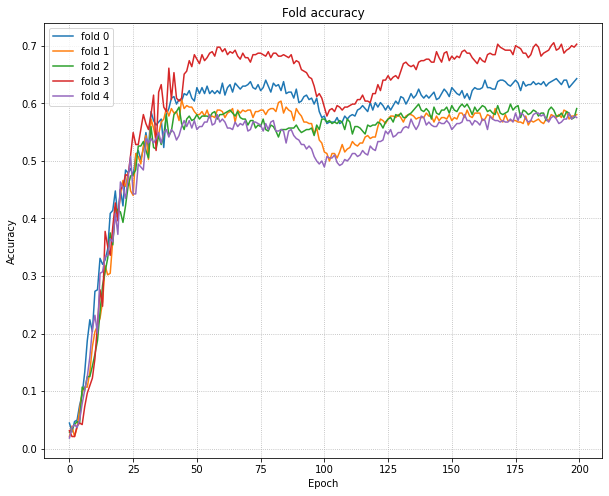

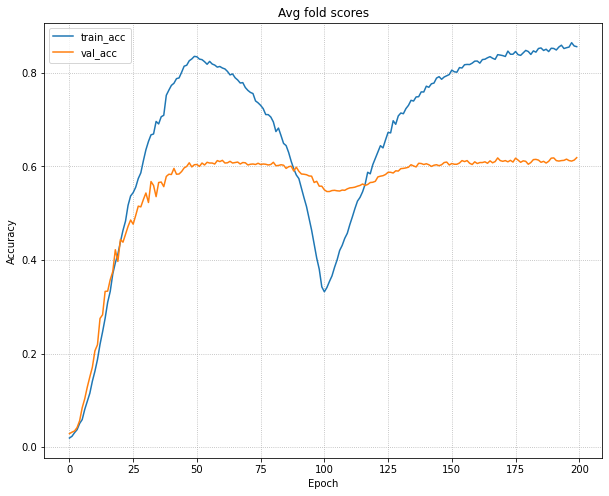

Best validation accuracy 0.7057291865348816 on fold 3.
Average on folds of the best validation accuracies: 0.6276041626930237.


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'
fold_history_blossy = np.load(os.path.join(SAVE_PATH, 'baseline_lossy.npy'), allow_pickle=True)

training_eval(fold_history_blossy)

## Test noise mixup

In [ ]:
SOURCE = path_base
MIXUP = 'noise'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'

batch_size = 64
epochs = 200

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]   

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP, wait_mix=50)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                                patience=5, min_lr=0.00001)

    baseline_model = make_baseConvNet(0.001)
    # Model training
    history = baseline_model.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                #    PlotLossesKeras(),
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                #    model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'baseline_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()
     



--- Training on fold 1 ---



Best validation accuracy: 0.6197916865348816

--- Training on fold 2 ---



Best validation accuracy: 0.6171875

--- Training on fold 3 ---



Best validation accuracy: 0.6354166865348816

--- Training on fold 4 ---



Best validation accuracy: 0.6796875

--- Training on fold 5 ---



Best validation accuracy: 0.59375



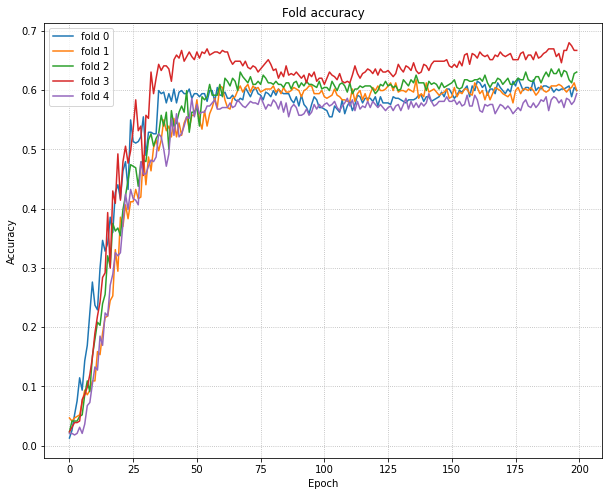

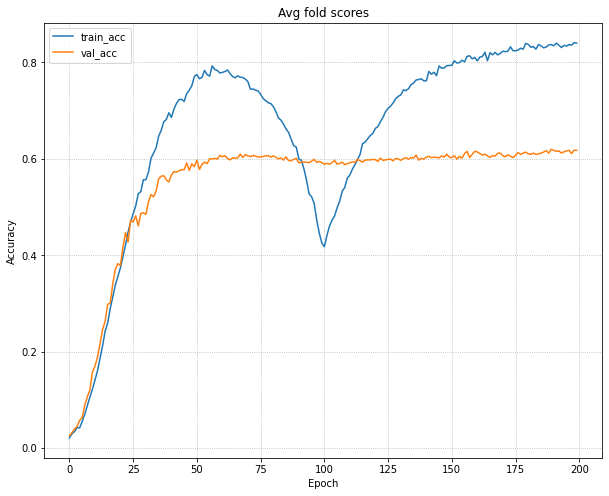

Best validation accuracy 0.6796875 on fold 3.
Average on folds of the best validation accuracies: 0.6291666746139526.


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'
fold_history_bnoise = np.load(os.path.join(SAVE_PATH, 'baseline_noise.npy'), allow_pickle=True)

training_eval(fold_history_bnoise)

# Part 2: YAMNet Transfer Learning

## Preprocessing and input pipeline functions

In [ ]:
class AudioLoader():
    def __init__(self, df, root, format1=True, downsample=True):
        self.df = df
        self.root = root
        self.format1 = format1
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.downsample:
            this_audio = samplerate.resample(this_audio, 16000/44100, converter_type='sinc_fastest')
        if self.format1:
            this_audio = this_audio / 32768     # 2^15 = 32768
        return this_audio

    def get_info(self, idx, list=False):
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out


def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed


def features_preprocessor(audio_loader, path, df, yamnet, augmentation=0):

    augment = am.Compose([
    am.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    am.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    am.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    am.Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),])


    if augmentation==0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            _, this_emb, _ = yamnet(this_audio)
            pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype= 'object')
            np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
            # break

    if augmentation > 0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            for aug in range(augmentation):
                
                if aug == 0:
                    _, this_emb, _ = yamnet(this_audio)
                    pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
                else:
                    aug_audio = augment(this_audio, sr)
                    _, this_emb, _ = yamnet(this_audio)
                    pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_'+str(aug)), pack)


        

## Offline preprocessing

In [ ]:
ic(ROOT)
AUGMENTATION = 0

!mkdir -p feature_storage
path_batch = "/content/feature_storage/"

# download ad set YAMNet pretrained model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

audio_loader = AudioLoader(data_info, ROOT, format1=True)
features_preprocessor(audio_loader, path_batch, data_info, yamnet_model, augmentation=AUGMENTATION)

ic| ROOT: '/content/ESC-50/audio/'


## Sequence class

In [ ]:
def to_onehot(y, classes=50):
    y_oh = np.zeros((classes, 1))
    y_oh[y] = 1
    return y_oh

def mix(a, b, l):
    return l*b + (1-l)*a


class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, alpha_schedule=None, mixup='none'):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.mixup = mixup
        self.epoch = 0
        self.alpha = [0.01, 0.01]
        self.mix_prob = 1
        if self.mixup != 'none':
            self.alpha_schedule = alpha_schedule
        else:
            self.alpha_schedule = None

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.mixup != 'none' and self.epoch < self.alpha_schedule.shape[1]:
            self.alpha = self.alpha_schedule[:,self.epoch]

        # print('deb alpha', self.alpha[0], self.alpha[1])
        random.shuffle(self.names)

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            this_feat = this_pack[0]
            this_target = to_onehot(this_pack[2])
            
            if self.mixup != 'none':
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                this_feat2 = np.roll(this_feat2, np.random.randint(0,10), axis=0)
                this_target2 = to_onehot(this_pack2[2])

                if self.mixup == 'lossy':
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, this_feat2, l)

                elif self.mixup == 'standard':
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, this_feat2, l)
                    this_target = mix(this_target, this_target2, l)  

                elif self.mixup == 'noise':
                    #use gaussian noise instead of the sample
                    feat2_std = np.std(this_feat2)
                    feat2_mean = np.mean(this_feat2)
                    noise_feat2 = np.random.normal(feat2_mean, feat2_std, this_feat2.shape)
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, noise_feat2, l)


            batch_feat.append(this_feat)
            batch_target.append(this_target)

        batch_infered = np.array(batch_feat)
        # ic(batch_infered.shape, type(batch_infered))

        batch_target = np.array(batch_target)
        batch_input = batch_infered

        return batch_input, batch_target


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

divide by zero encountered in power



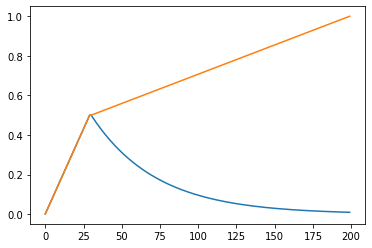

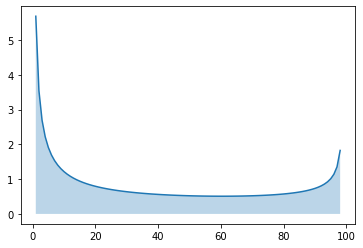

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.5
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end
alpha_schedule[0,30:] = alpha_end*np.exp(-np.linspace(0,4, 170))
alpha_schedule[1,30:] = np.linspace(alpha_end, 1, 170)
plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

## Fine tuning model

In [ ]:
def make_tfYAMNet(size_1=100, size_2=100, size_3=50, lr=1e-3):

    input_inf = layers.Input(shape=(None,1024))
    
    z = layers.GlobalAveragePooling1D()(input_inf)

    z = tf.expand_dims(z, axis=1)
    z = layers.Conv1D(size_1, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(size_2, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(size_3, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(50, 1, padding='same', activation='softmax')(z)
    z = layers.GlobalAveragePooling1D()(z)
    
    model = keras.Model(inputs=input_inf, outputs=z)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model

tfyam_net = make_tfYAMNet()
tfyam_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1024)]      0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1, 1024)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 100)            102500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 100)            10100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 50)             5050      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 50)             2550  

## Optuna hyperparameters search

In [ ]:
SOURCE = path_batch
READ_AUG = False
fold = 2

def objective(trial):
   
    epochs = 125
    batch_size = trial.suggest_int('batch_size', 32,256)
    size_1 = trial.suggest_int('size_1', 50, 200)
    size_2 = trial.suggest_int('size_2', 50, 200)
    size_3 = trial.suggest_int('size_3', 50, 200)
    lr = lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)


    # feat_names  = os.listdir(path_drive)
    feat_names  = os.listdir(SOURCE)
    # ic(len(feat_names))

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]    

    # ic(len(train_names))
    # ic(len(val_names))

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup='lossy')
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, mixup='none')


    # ic(len(train_dataloader))
    # ic(len(val_dataloader))

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=5, min_lr=0.00005)


    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    # load the best model checkpoint
    tfyam_net.load_weights(model_checkpoint_file)
    best_acc = max(history.history['val_accuracy'])
    
    return best_acc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=int(2.5*60*60))

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2021-06-16 13:44:13,571] A new study created in memory with name: no-name-66e92ae5-731e-480f-82fa-253ede2f5d26
[I 2021-06-16 13:49:44,336] Trial 0 finished with value: 0.893750011920929 and parameters: {'batch_size': 160, 'size_1': 198, 'size_2': 123, 'size_3': 199, 'lr': 0.00031874152012530664}. Best is trial 0 with value: 0.893750011920929.
[I 2021-06-16 13:56:17,126] Trial 1 finished with value: 0.8958333134651184 and parameters: {'batch_size': 84, 'size_1': 173, 'size_2': 198, 'size_3': 188, 'lr': 0.00029668375120813254}. Best is trial 1 with value: 0.8958333134651184.
[I 2021-06-16 14:01:47,433] Trial 2 finished with value: 0.8892045617103577 and parameters: {'batch_size': 88, 'size_1': 123, 'size_2': 94, 'size_3': 133, 'lr': 0.0007229764736567732}. Best is trial 1 with value: 0.8958333134651184.
[I 2021-06-16 14:06:51,291] Trial 3 finished with value: 0.02469135820865631 and parameters: {'batch_size': 162, 'size_1': 130, 'size_2': 172, 'size_3': 194, 'lr': 0.07001342456360396}

val Loss: 0.9194312691688538
Best hyperparameters: {'batch_size': 211, 'size_1': 189, 'size_2': 158, 'size_3': 186, 'lr': 0.0007880421706148033}


In [ ]:
best_params = {'batch_size': 211, 'size_1': 189, 'size_2': 158, 'size_3': 186, 'lr': 0.0007880421706148033}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

## Test with standard mixup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in power



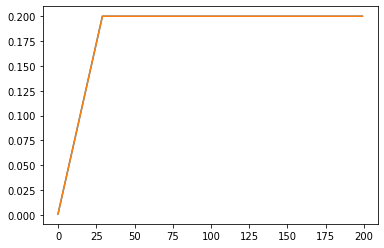

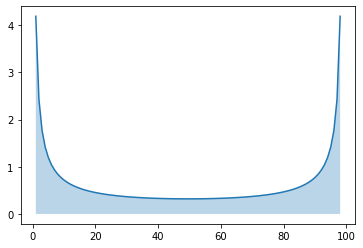

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.2
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end

plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

In [ ]:
SOURCE = path_batch
MIXUP = 'standard'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'

batch_size = best_params['batch_size']
size_1 = best_params['size_1']
size_2 = best_params['size_2']
size_3 = best_params['size_3']
lr = best_params['lr']

epochs = 125

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]  

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                patience=5, min_lr=0.00001)

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()




--- Training on fold 1 ---



Best validation accuracy: 0.8815165758132935

--- Training on fold 2 ---



Best validation accuracy: 0.8862559199333191

--- Training on fold 3 ---



Best validation accuracy: 0.9052132964134216

--- Training on fold 4 ---



Best validation accuracy: 0.900473952293396

--- Training on fold 5 ---



Best validation accuracy: 0.9099525809288025



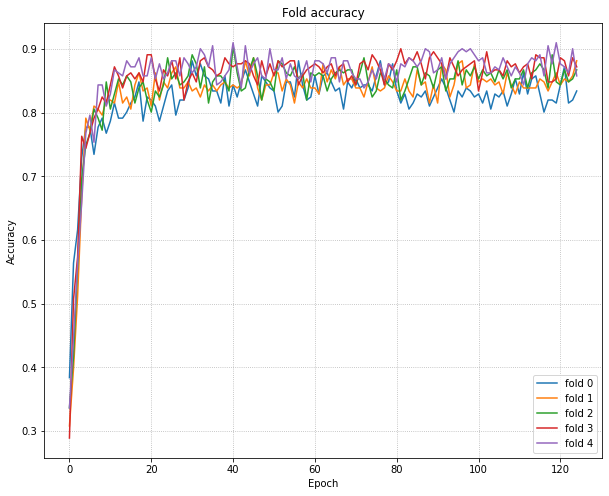

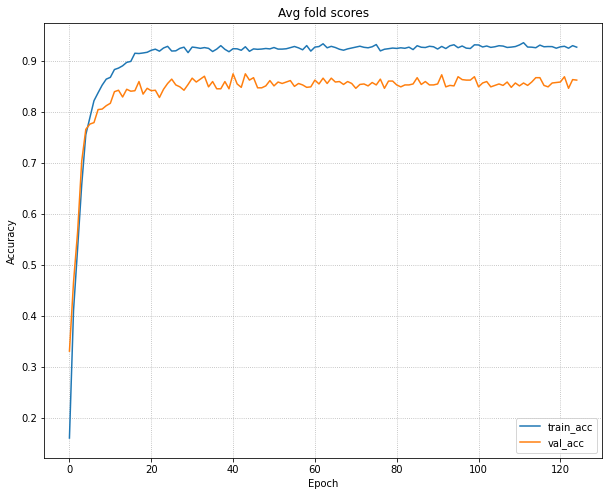

Best validation accuracy 0.9099525809288025 on fold 4.
Average on folds of the best validation accuracies: 0.8966824650764466.


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'
fold_history_standard = np.load(os.path.join(SAVE_PATH, 'tfyamnet_standard.npy'), allow_pickle=True)

training_eval(fold_history_standard)

## Test lossy mixup

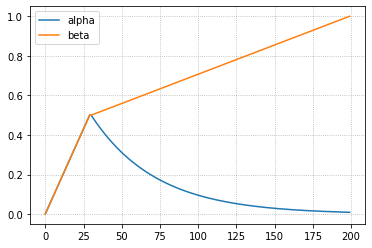

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning:

divide by zero encountered in power



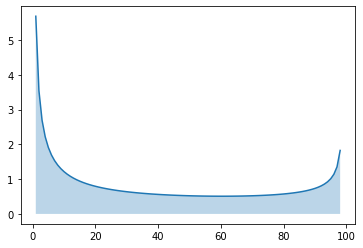

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.5
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end
alpha_schedule[0,30:] = alpha_end*np.exp(-np.linspace(0,4, 170))
alpha_schedule[1,30:] = np.linspace(alpha_end, 1, 170)
plt.figure()
plt.plot(alpha_schedule[0], label='alpha')
plt.plot(alpha_schedule[1], label='beta')
plt.legend()
plt.grid(linestyle=':')
plt.show()

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )
plt.show()

In [ ]:
SOURCE = path_batch
MIXUP = 'lossy'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'

batch_size = best_params['batch_size']
size_1 = best_params['size_1']
size_2 = best_params['size_2']
size_3 = best_params['size_3']
lr = best_params['lr']

epochs = 125

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]  

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                patience=5, min_lr=0.00005)

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_'+MIXUP+'_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()

--- Training on fold 1 ---



Best validation accuracy: 0.8625592589378357

--- Training on fold 2 ---



Best validation accuracy: 0.9146919250488281

--- Training on fold 3 ---



Best validation accuracy: 0.9099525809288025

--- Training on fold 4 ---



Best validation accuracy: 0.900473952293396

--- Training on fold 5 ---



Best validation accuracy: 0.9241706132888794



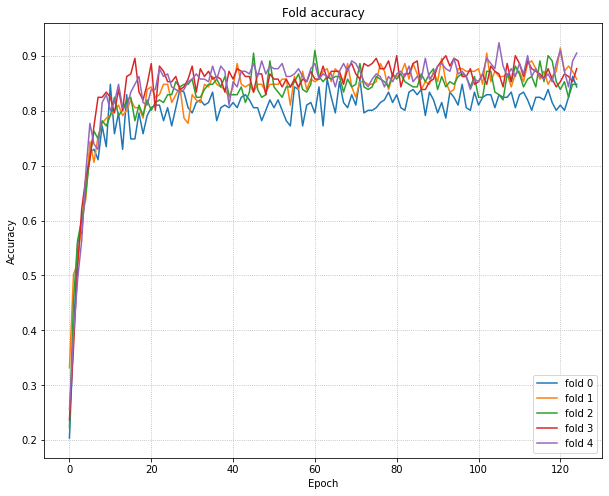

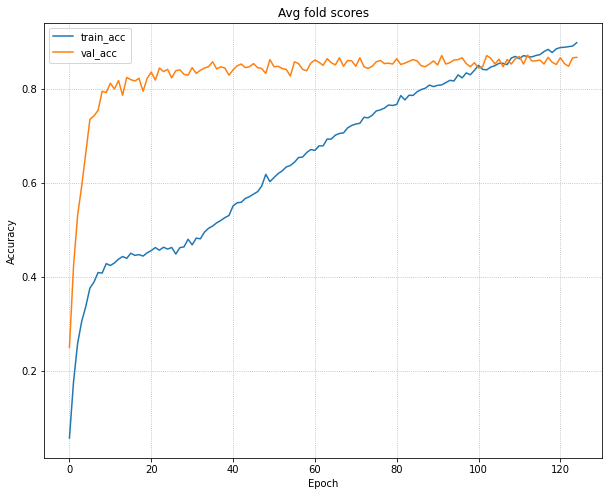

Best validation accuracy 0.9241706132888794 on fold 4.
Average on folds of the best validation accuracies: 0.9023696660995484.


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'
fold_history_lossy = np.load(os.path.join(SAVE_PATH, 'tfyamnet_lossy.npy'), allow_pickle=True)

training_eval(fold_history_lossy)

## Comparison with noisy mix up

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

divide by zero encountered in power



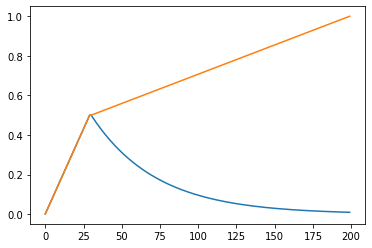

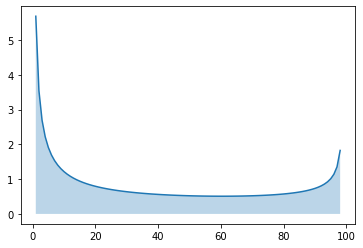

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.5
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end
alpha_schedule[0,30:] = alpha_end*np.exp(-np.linspace(0,4, 170))
alpha_schedule[1,30:] = np.linspace(alpha_end, 1, 170)
plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

In [ ]:
SOURCE = path_batch
MIXUP = 'noise'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'

batch_size = best_params['batch_size']
size_1 = best_params['size_1']
size_2 = best_params['size_2']
size_3 = best_params['size_3']
lr = best_params['lr']

epochs = 125

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]  

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                patience=5, min_lr=0.00005)

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_'+MIXUP+'_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()

--- Training on fold 1 ---



Best validation accuracy: 0.8341231942176819

--- Training on fold 2 ---



Best validation accuracy: 0.8862559199333191

--- Training on fold 3 ---



Best validation accuracy: 0.8957346081733704

--- Training on fold 4 ---



Best validation accuracy: 0.9146919250488281

--- Training on fold 5 ---



Best validation accuracy: 0.9052132964134216



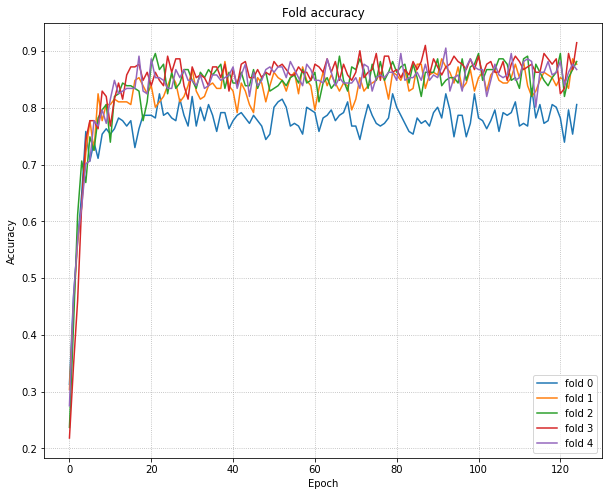

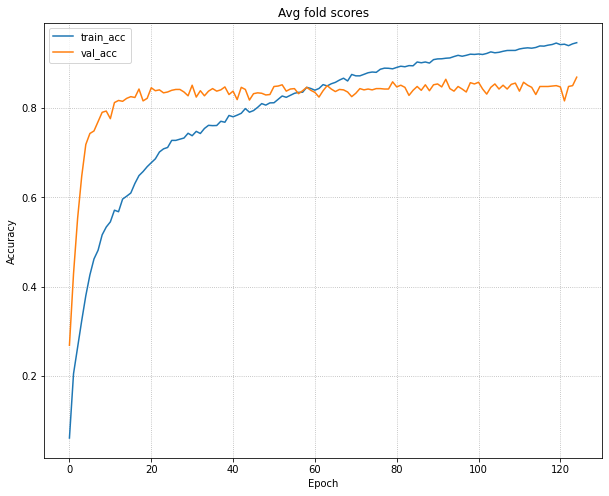

Best validation accuracy 0.9146919250488281 on fold 3.
Average on folds of the best validation accuracies: 0.8872037887573242.


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'
fold_history_noise = np.load(os.path.join(SAVE_PATH, 'tfyamnet_noise.npy'), allow_pickle=True)

training_eval(fold_history_noise)

## test with no mixup

In [ ]:
SOURCE = path_batch
MIXUP = 'none'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'

batch_size = best_params['batch_size']
size_1 = best_params['size_1']
size_2 = best_params['size_2']
size_3 = best_params['size_3']
lr = best_params['lr']

epochs = 125

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]  

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                patience=5, min_lr=0.00005)

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_'+MIXUP+'_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()

--- Training on fold 1 ---



Best validation accuracy: 0.8578199148178101

--- Training on fold 2 ---



Best validation accuracy: 0.8909952640533447

--- Training on fold 3 ---



Best validation accuracy: 0.8909952640533447

--- Training on fold 4 ---



Best validation accuracy: 0.9099525809288025

--- Training on fold 5 ---



Best validation accuracy: 0.9099525809288025



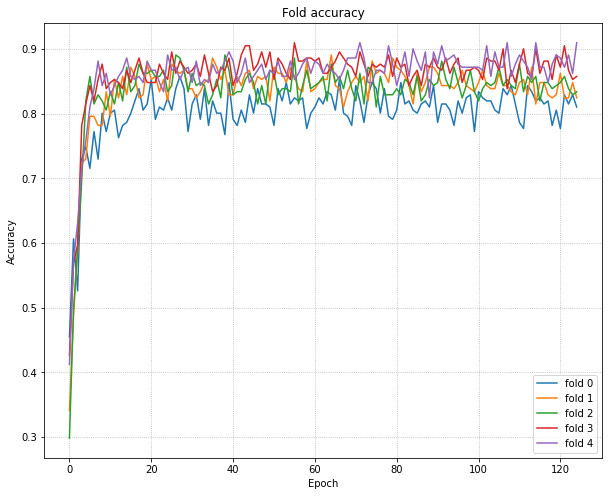

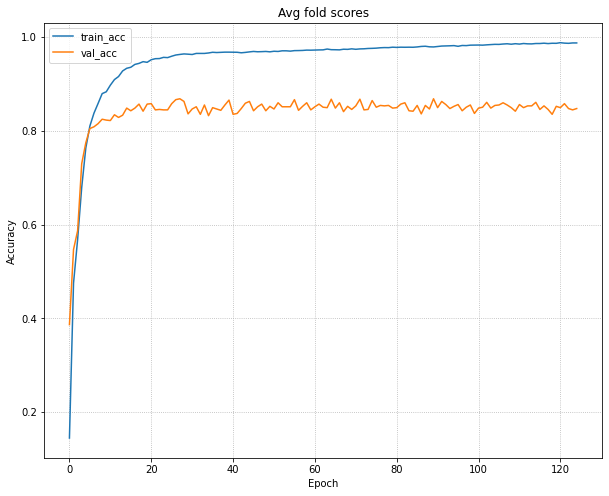

Best validation accuracy 0.9099525809288025 on fold 3.
Average on folds of the best validation accuracies: 0.8919431209564209.


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'
fold_history_none = np.load(os.path.join(SAVE_PATH, 'tfyamnet_none.npy'), allow_pickle=True)

training_eval(fold_history_none)

# Part 3: Final Demonstration on an audio sequence

Define again the necessary functions, and modify the dataloader in order to give samples from a specific fold.

In [6]:
import IPython as IP

class AudioLoader():
    def __init__(self, df, fold, root, format1=False, downsample=True):
        self.df = df
        self.root = root
        self.fold = fold
        self.format1 = format1
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        idx = (self.fold-1)*400 + idx
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.downsample:
            this_audio = samplerate.resample(this_audio, 16000/44100, converter_type='sinc_fastest')
        if self.format1:
            this_audio = this_audio / 32768     # 2^15 = 32768
        return this_audio

    def get_info(self, idx, list=False):
        idx = (self.fold-1)*400 + idx
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out

def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed

def make_tfYAMNet(size_1=100, size_2=100, size_3=50, lr=1e-3):

    input_inf = layers.Input(shape=(None,1024))
    
    z = layers.GlobalAveragePooling1D()(input_inf)

    z = tf.expand_dims(z, axis=1)
    z = layers.Conv1D(size_1, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(size_2, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(size_3, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(50, 1, padding='same', activation='softmax')(z)
    z = layers.GlobalAveragePooling1D()(z)
    
    model = keras.Model(inputs=input_inf, outputs=z)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model


Load the weights of the best trained model.
Since it was trained using the fold 5 as validation set, we use samples from fold 5 to provide never-seen data to the model. 

In [7]:
model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
# best parameters from optuna search
best_params = {'batch_size': 211, 'size_1': 189, 'size_2': 158, 'size_3': 186, 'lr': 0.0007880421706148033}

best_model = make_tfYAMNet(best_params['size_1'], best_params['size_2'],best_params['size_3'], best_params['lr'] )
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1024)]      0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1, 1024)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 189)            193725    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 158)            30020     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 186)            29574     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 50)             9350  

Load the YAMNet model that is used as a feature extractor bedore the fine tuning model

In [8]:
# download ad set YAMNet pretrained model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)
best_model.load_weights(os.path.join(model_checkpoint_dir, 'best_model_lossy_fold_5'))

Example of the features extracted by the YAMNet module

Category: frog


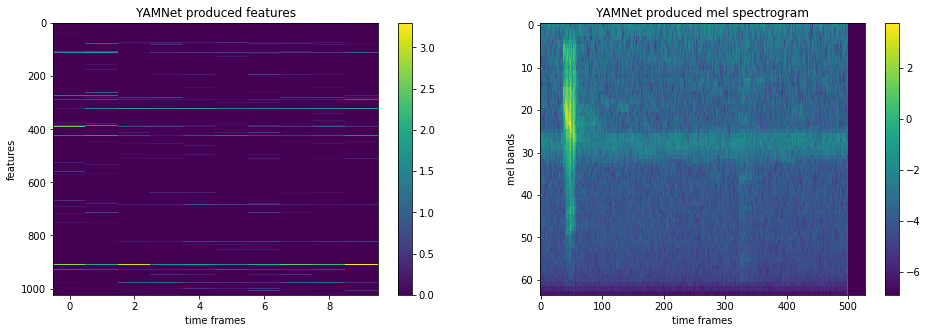

In [10]:
fold5_audio_loader = AudioLoader(data_info, 5, ROOT, format1=True)
_, emb, spec = yamnet_model(fold5_audio_loader[20])
this_cat = fold5_audio_loader.get_info(20)['category']
print(f'Category: {this_cat}')
emb = emb.numpy()
spec = spec.numpy()

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title('YAMNet produced features')
plt.imshow(emb.T, aspect='auto', interpolation='nearest')
plt.xlabel('time frames')
plt.ylabel('features')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('YAMNet produced mel spectrogram')
plt.imshow(spec.T, aspect='auto', interpolation='nearest')
plt.xlabel('time frames')
plt.ylabel('mel bands')
plt.colorbar()

plt.show()

## Generate a random audio sequence
Randomly choose from the fold 5 to generate an audio sequence
While building the sequence we apply the same preprocessing steps used during the training 

Chosen files indexed inside the fold: 
[260  19 324 228 399]

Category of the chosen samples: 
['clapping', 'frog', 'engine', 'crickets', 'dog']



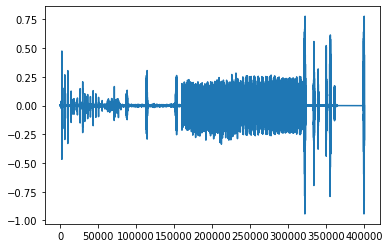

In [17]:
fold5_audio_loader = AudioLoader(data_info, 5, ROOT, format1=True)

n = 5
SR = 16000

def to_onehot(y, classes=50):
    y_oh = np.zeros((classes, 1))
    y_oh[y] = 1
    return y_oh

sequence_choice = np.random.randint(0,400, (n,))
print(f'Chosen files indexed inside the fold: \n{sequence_choice}\n')

sequence_audio = np.zeros((n*5*SR,))
sequence_label = np.zeros((n,50))
sequence_cat = []
for i in range(n):
    curr_audio = removeSilence(fold5_audio_loader[sequence_choice[i]], True)
    # curr_audio = (curr_audio - np.min(curr_audio))/(np.max(curr_audio) - np.min(curr_audio))
    sequence_audio[i*5*SR:(i+1)*5*SR-1] = curr_audio
    sequence_label[i] = np.squeeze(to_onehot(fold5_audio_loader.get_info(sequence_choice[i])['target']), axis=-1)
    sequence_cat.append(fold5_audio_loader.get_info(sequence_choice[i])['category'])

print(f'Category of the chosen samples: \n{sequence_cat}\n')

plt.plot(sequence_audio)
plt.show()


Listen to the audio sequence

In [19]:
IP.display.Audio(sequence_audio, rate=SR)

## Perform the classification using YAMNet and the fine tuning model

We can evaluate the performance of the classifier also by comparing the strength of the most probable class and the mean of the less probable classes.
We call this simple metric 'confidence':
$$confidence(\mathbf{x})=max(\mathbf{x})-\frac{1}{len(\mathbf{x})-1}\sum x_i \quad if \quad i \neq argmax(\mathbf{x})$$.

We expect confidence close to 1 with a correct classification and confidence close to 0 for incorrect classification 

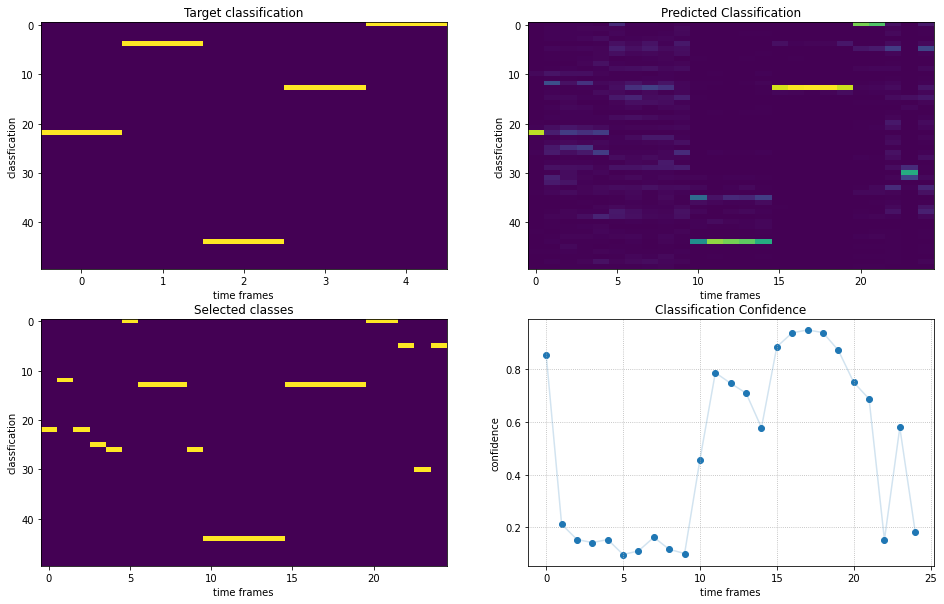

In [18]:
classification = np.zeros((int(sequence_audio.shape[0]/(1*SR)), 50))
class_sel = np.zeros(classification.shape)



def confidence_func(x):
    predicted_value = np.max(x)
    predicted_class = np.argmax(x)
    avg_less = np.mean(x[x!=predicted_class])
    conf = predicted_value - avg_less
    return conf

confidence = []
scce = tf.keras.losses.SparseCategoricalCrossentropy()
cat_record = []
for i in notebook.tqdm(range(classification.shape[0])):
    curr_audio = sequence_audio[i*(1*SR):(i+1)*(1*SR)]
    # curr_audio = (curr_audio - np.min(curr_audio))/(np.max(curr_audio) - np.min(curr_audio))
    _, emb, _ = yamnet_model(sequence_audio[i*(1*SR):(i+1)*(1*SR)])
    emb = np.expand_dims(emb, axis=0)
    pred = best_model(emb).numpy()
    classification[i,:] = pred
    cat_record.append(category_dict[np.argmax(pred)])
    confidence.append(confidence_func(pred))
    class_sel[i,:] = np.squeeze(to_onehot(np.argmax(pred)))

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.title('Target classification')
plt.imshow(sequence_label.T, interpolation='nearest', aspect='auto')
plt.xlabel('time frames')
plt.ylabel('classfication')
# plt.colorbar()

plt.subplot(2,2,2)
plt.title('Predicted Classification')
plt.imshow(classification.T, interpolation='nearest', aspect='auto')
plt.xlabel('time frames')
plt.ylabel('classfication')
# plt.colorbar()

plt.subplot(2,2,3)
plt.title('Selected classes')
plt.imshow(class_sel.T, interpolation='nearest', aspect='auto')
plt.xlabel('time frames')
plt.ylabel('classfication')
# plt.colorbar()


plt.subplot(2,2,4)
plt.title('Classification Confidence')
plt.scatter(np.arange(len(confidence)), confidence)
plt.plot(confidence, alpha=0.2)
plt.xlabel('time frames')
plt.ylabel('confidence')
plt.grid(linestyle=':')
plt.show()